#### Plot winds along transect in Beaufort Sea from WRF experiments and ERA5 

#### Author: Jonathan Rheinlænder*
#### Date: Aug. 27 2021
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no

In [1]:
%matplotlib notebook
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from pathlib import Path  
import sys
import xarray as xr
import matplotlib.colors as colors
import cartopy 
import cartopy.crs as ccrs
import pyproj
import matplotlib.gridspec as gridspec
import cmocean
import argparse
import locale 

In [103]:

def get_transect(xr, start_time, end_time, xpoint, ypoint):

    time_slice = slice(start_time, end_time)
    x_slice = xpoint[0]
    y_slice = slice(ypoint[0], ypoint[1])

    transect = xr.sel(time=time_slice, x=x_slice, y=y_slice)

    # make array of datetime objects
    vtimes = transect.time.values.astype('datetime64[ms]').astype('O')

    # Specify y values for transect
    length = y_slice.stop - y_slice.start
    res = 5 # 5 km grid spacing
    ydist = np.arange(0,length*res, res) # distance in km from Banks Island (y0)

    return ydist, vtimes, transect

def plot_map(ax):

    lons = ds.longitude[:] #dims:y,x
    lats = ds.latitude[:]

    # find lon,lat coordinates for x,y points
    lon0 = lons[ypoint[0]][xpoint[0]]
    lon1 = lons[ypoint[1]][xpoint[1]]
    lat0 = lats[ypoint[0]][xpoint[0]]
    lat1 = lats[ypoint[1]][xpoint[1]]
    lon = (lon0, lon1)
    lat = (lat0, lat1)
    
    proj = ccrs.NorthPolarStereo(central_longitude=-45)
    ax.set_extent([-2611832.880671568, -369765.49428808136, -1058480.3928495955, 1951306.484993737], crs=ax.projection) 

    ax.add_feature(cartopy.feature.LAND,zorder=1,alpha=1) 
    ax.coastlines(resolution='50m', linewidth=0.5) 
    ax.gridlines(draw_labels=False, linestyle='dotted')
    ax.plot(lon, lat, 'ro-', transform=ccrs.Geodetic()) # geodetic plots shortest distance 
    ax.patch.set_alpha(0.5)

def plot_transect(ax, vname, add_insetmap=True):
    global clabel, figname, cmap, clim, cb_extend
    clabel, figname, cmap, clim, cb_extend = _PLOT_INFO[vname]
    
    #print("Start plotting", vname)
    #fig = plt.figure(figsize=(8, 3))
    #fig.subplots_adjust(bottom=0.2, top=0.90, left=0.1, right=0.95, wspace=0.01, hspace=0.01)
    #ax = fig.add_subplot(111)
    
    if np.size(clim)==2: #contineous colormap 
        cf = ax.contourf(vtimes, yvals, transect.transpose(), 
        vmin=clim[0], vmax=clim[1], cmap=cmap, extend=cb_extend)
    else: #discrete colormap
        clevs = np.arange(clim[0], clim[1]+clim[2],clim[2])
        cf = ax.contourf(vtimes, yvals, transect.transpose(), 
            levels=clevs, cmap=cmap, extend=cb_extend)

    # add contour at 10m/s
    cline = ax.contour(vtimes, yvals, transect.transpose(), levels=[10],  colors='k', linewidths=0.5)
    
    # add colorbar
    #cax,kw = mpl.colorbar.make_axes(ax,location='right')
    cax = fig.add_axes([0.915, 0.3, 0.01, 0.5])
    cbar=fig.colorbar(cf,cax=cax)
    cbar.set_label(clabel)
    #cbar = plt.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, aspect=50)
    #cbar.set_label(clabel)  

    # set labels
    locale.setlocale(locale.LC_ALL,'en_US')  # change language to EN
    days = mdates.DayLocator()  # every day
    dtFmt = mdates.DateFormatter('%b %d') # define the formatting 
    ax.xaxis.set_major_formatter(dtFmt)
    ax.xaxis.set_minor_locator(days)
    plt.xticks(rotation=45) # rotate xlabels
    ax.set_ylabel("y")

    # add map 
    if add_insetmap:
        proj = ccrs.NorthPolarStereo(central_longitude=-45)
        ax_inset = fig.add_axes([0.061, 0.21, 0.2, 0.4], projection=proj)
        plot_map(ax_inset) 


In [3]:
def plot_vectors(ax, ds, xloc, yloc):
    
    time = ds['time']
    u = ds['wndx'].sel(x=xloc, y=yloc).squeeze()
    v = ds['wndy'].sel(x=xloc, y=yloc).squeeze()

    # calculate the magnitude
    scale=2
    magnitude = (u**2 + v**2)**0.5
    maxmag = max(magnitude)/scale
    ax.set_ylim(-maxmag, maxmag)
    xint = 2 # set interval
    q = ax.quiver(time[::xint], 0, u[::xint],v[::xint],  
           color='r',
           units='y',
           scale_units='y',
           scale = 2,
           headlength=2,
           headaxislength=2,
           width=0.1,
           alpha=1
              )

    qk = plt.quiverkey(q,0.15, 0.2, 5,
               r' 5 m/s',
               labelpos='W',
               fontproperties={'weight': 'normal'})

    # Fake 'box' to be able to insert a legend'
#    p = ax.add_patch(plt.Rectangle((1,1),1,1,fc='w',alpha=1))
#    leg1 = ax.legend([p], ["[x, y]=" + "["+str(xloc)+", "+str(yloc)+"]"],loc='lower right')
#    leg1._drawFrame=False

    # add horizontal line at y=0
    ax.axhline(linewidth=1, color='grey', alpha=0.2)

    ax.set_xlim(min(time),max(time))
    ax.set_yticklabels([])
    ax.grid(linestyle="--", alpha=0.4)


In [108]:
# main

# create dictionary for plotting different variables
_PLOT_INFO =dict(
    wspeed = ('Wind speed (m s$^{-1}$)', 'wspeed_transect_beaufort','RdYlBu_r', [0,20,1], 'max'),
    icevel = ('ice velocity [m/s]', 'icevel_transect_beaufort', cmocean.cm.speed, [0, 0.4, 0.02], 'max'),
)


<IPython.core.display.Javascript object>


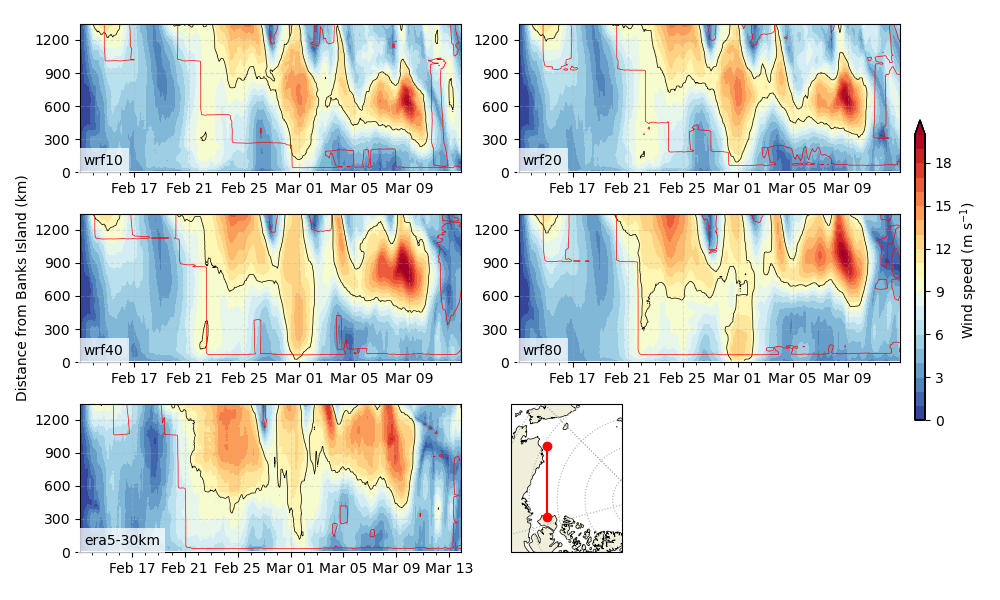

loading /cluster/projects/nn9624k/rheinlender/breakup2013/data/wrf-exp/start_20130213_nudging/expt_01_wrf10/outputs-v11/Moorings.nc
loading /cluster/projects/nn9624k/rheinlender/breakup2013/data/wrf-exp/start_20130213_nudging/expt_02_wrf20/outputs/Moorings.nc


/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


loading /cluster/projects/nn9624k/rheinlender/breakup2013/data/wrf-exp/start_20130213_nudging/expt_03_wrf40/outputs/Moorings.nc


/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


loading /cluster/projects/nn9624k/rheinlender/breakup2013/data/wrf-exp/start_20130213_nudging/expt_04_wrf80/outputs/Moorings.nc


/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


loading /cluster/projects/nn9624k/rheinlender/breakup2013/data/wrf-exp/start_20130213_nudging/expt_00_era5/outputs/Moorings.nc


/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


done
Saving /cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/wspeed_transect_beaufort_20130213-20130313_all-expts.png


In [109]:
# Plot ice velocity along transect
plt.close('all')

outdir =  '/cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/'
inpath ='/cluster/projects/nn9624k/rheinlender/breakup2013/data/wrf-exp/start_20130213_nudging/'
expts = ["expt_01_wrf10/outputs-v11/", "expt_02_wrf20/outputs/","expt_03_wrf40/outputs/",
         "expt_04_wrf80/outputs/", "expt_00_era5/outputs/"]
expts_names = ["wrf10", "wrf20","wrf40","wrf80", "era5-30km"]

# Create slice variables subset domain
vname=['wspeed', 'icevel']
start_time = '2013-02-11'
end_time = '2013-03-13'
xpoint = (100, 100)
ypoint = (180, 450)

fig = plt.figure(figsize=(10,6)) #create one of the figures that must appear with the chart
gs = gridspec.GridSpec(3,2) # without velocity vectors
fig.subplots_adjust(bottom=0.08, top=0.96, left=0.08, right=0.9, wspace=0.15, hspace=0.28)

for i, dirs in enumerate(expts):
    fl = inpath + dirs + 'Moorings.nc'
    print("loading", fl)
    ds = xr.open_dataset(fl) # load data
    
    ax2 = fig.add_subplot(gs[i])
    
    # calculate ice velocity 
    #ds['icevel'] = (ds['siu']**2 + ds['siv']**2)**0.5
    for var in vname:
        if var=="icevel":
            # calculate ice velocity 
            ds[var] = (ds['siu']**2 + ds['siv']**2)**0.5
            ds[var] = ds[var]*100 # convert to cm/s
            ds[var].attrs["units"] = "cm s$^{-1}$"
            
            yvals, vtimes, transect = get_transect(ds[var], start_time, end_time, xpoint, ypoint)

            cline = ax2.contour(vtimes, yvals, transect.transpose(), levels=[5],  
                                   colors='r', linestyles='-',linewidths=0.5)
        else:
            yvals, vtimes, transect = get_transect(ds[var], start_time, end_time, xpoint, ypoint)
            plot_transect(ax2, var, add_insetmap=False)

    # set title
    # add title inside subplots
    ax2.text(0.01,0.05,expts_names[i],horizontalalignment='left',
        transform=ax2.transAxes, bbox=dict(facecolor='white', edgecolor='None', alpha=0.75))
    #ax2.set_title(expts_names[i])
    
    # label stuff
    ax2.set_ylabel((''))
    ax2.yaxis.set_ticks(np.arange(yvals[0], yvals[-1], step=300))  # Set label locations.
    ax2.grid(linestyle='--', alpha=0.3)
    
    if i==2:
        ax2.set_ylabel('Distance from Banks Island (km)')
        
# add inset map in last subplot
ax6 = fig.add_subplot(gs[i+1], projection=ccrs.NorthPolarStereo(central_longitude=-45))
pos=ax6.get_position()
pnts=pos.get_points()
pnts[0,0] =0.35
pos.set_points(pnts)
#print(pos)
ax6.set_position(pos)

plot_map(ax6)
     
#fig.subplots_adjust(bottom=0.08, top=0.96, left=0.08, right=0.9,wspace=0.18, hspace=0.1)
#plt.show()

print("done")
# save figure
figname = os.path.join(outdir,
      '%s_%s-%s_%s' % (figname, vtimes[0].strftime('%Y%m%d'), vtimes[-1].strftime('%Y%m%d'),"all-expts"))
figname = figname + '.png'
os.makedirs(os.path.dirname(figname), exist_ok=True)
print(f'Saving {figname}')
fig.savefig(figname, dpi=300, bbox_inches='tight')
